# Control Policy Training

For this pipeline, I focused on getting a model of any component of my problem to train and show results. I continued training with my previously outlined observation space, action space, and reward function. However, during the last pipeline, I prioritized setting up the simulation. Thus, the reinforcement learning problem definition (observation space, action space, and reward function) wasn't realistic and thus didn't enable training.  

Thus, for this pipeline, I decided to go back to deeply understand the paper that already attempted to solve my problem of training quadrup soccer robots to kick the ball. That process helped a lot and exposed the weak points of my previous pipeline. As such, here are the stages I passed to iterate from an outline earlier:  
1. Read and annotate Ji et. al's paper (2022)  
2. Plot the control and planning policies reward functions to experiment with its parameters  
3. Sketch the training pipeline  
4. Sketch the control policy training components and steps  
5. Rewrite the observation space and reset methods according to the new control policy observation space  

The main takeaway of the paper is breaking down the soccer shooting task into two different policies! For a human to shoot a soccer ball towards the goal, the following two stages need to happen:  
1. Estimating the desired ball trajectory in the player's head  
2. Executing the shooting task by kicking the ball  

As we can see, these are two distinct skills that soccer players train to master. Similarly, it's essential to separate them during our training to optimize the training. As such, we'll separate the the shooting task for the robot to the following:  
1. Motion planning: deciding the ideal robot toe (front right leg end-effector) movement that leads to scoring a goal (within 0.2m of the goal)  
    * This is represented by a planning policy that takes in the ball and goal positions, past ball positions, last action, joint positions, orientation, and current kicking phase motion indicator. And using a reward function that incentivizes bring the ball closer to the goal while staying upright, we get the output as the optimal trajectory of the toe that leads to a kicking motion. The output for each kicking motion component is in the form of bezier curve parameters.  
2. Motion control: deciding how to track a bezier curve with a robot toe without falling
    * This is represented by a control policy that takes in the current kicking phase indicatior, bezier parameters, joint positions, robot orientation, past actions, past states. And using a reward function that incentivizes tracking the bezier curve with the robot toe as closely as possible, we get the output as the optimal joint values that bring the toe to track the bezier curve

As training the motion planning policy requires the robot to be able to kick the ball (tracking a bezier curve with its toe), we need to train the control policy first. As such, I have focused on bringing up the control policy training for this pipeline. For the next pipeline, I will focus on continuing the control policy pipeline and potentially setting up the planning policy training as well.

Below, we can see the planning policy reward function. Here, the goal is at x = 0 and we can see that the reward increases as the ball gets closer to the goal. When the ball is within 0.2 meters from the goal, the reward function is set to 1 (max)

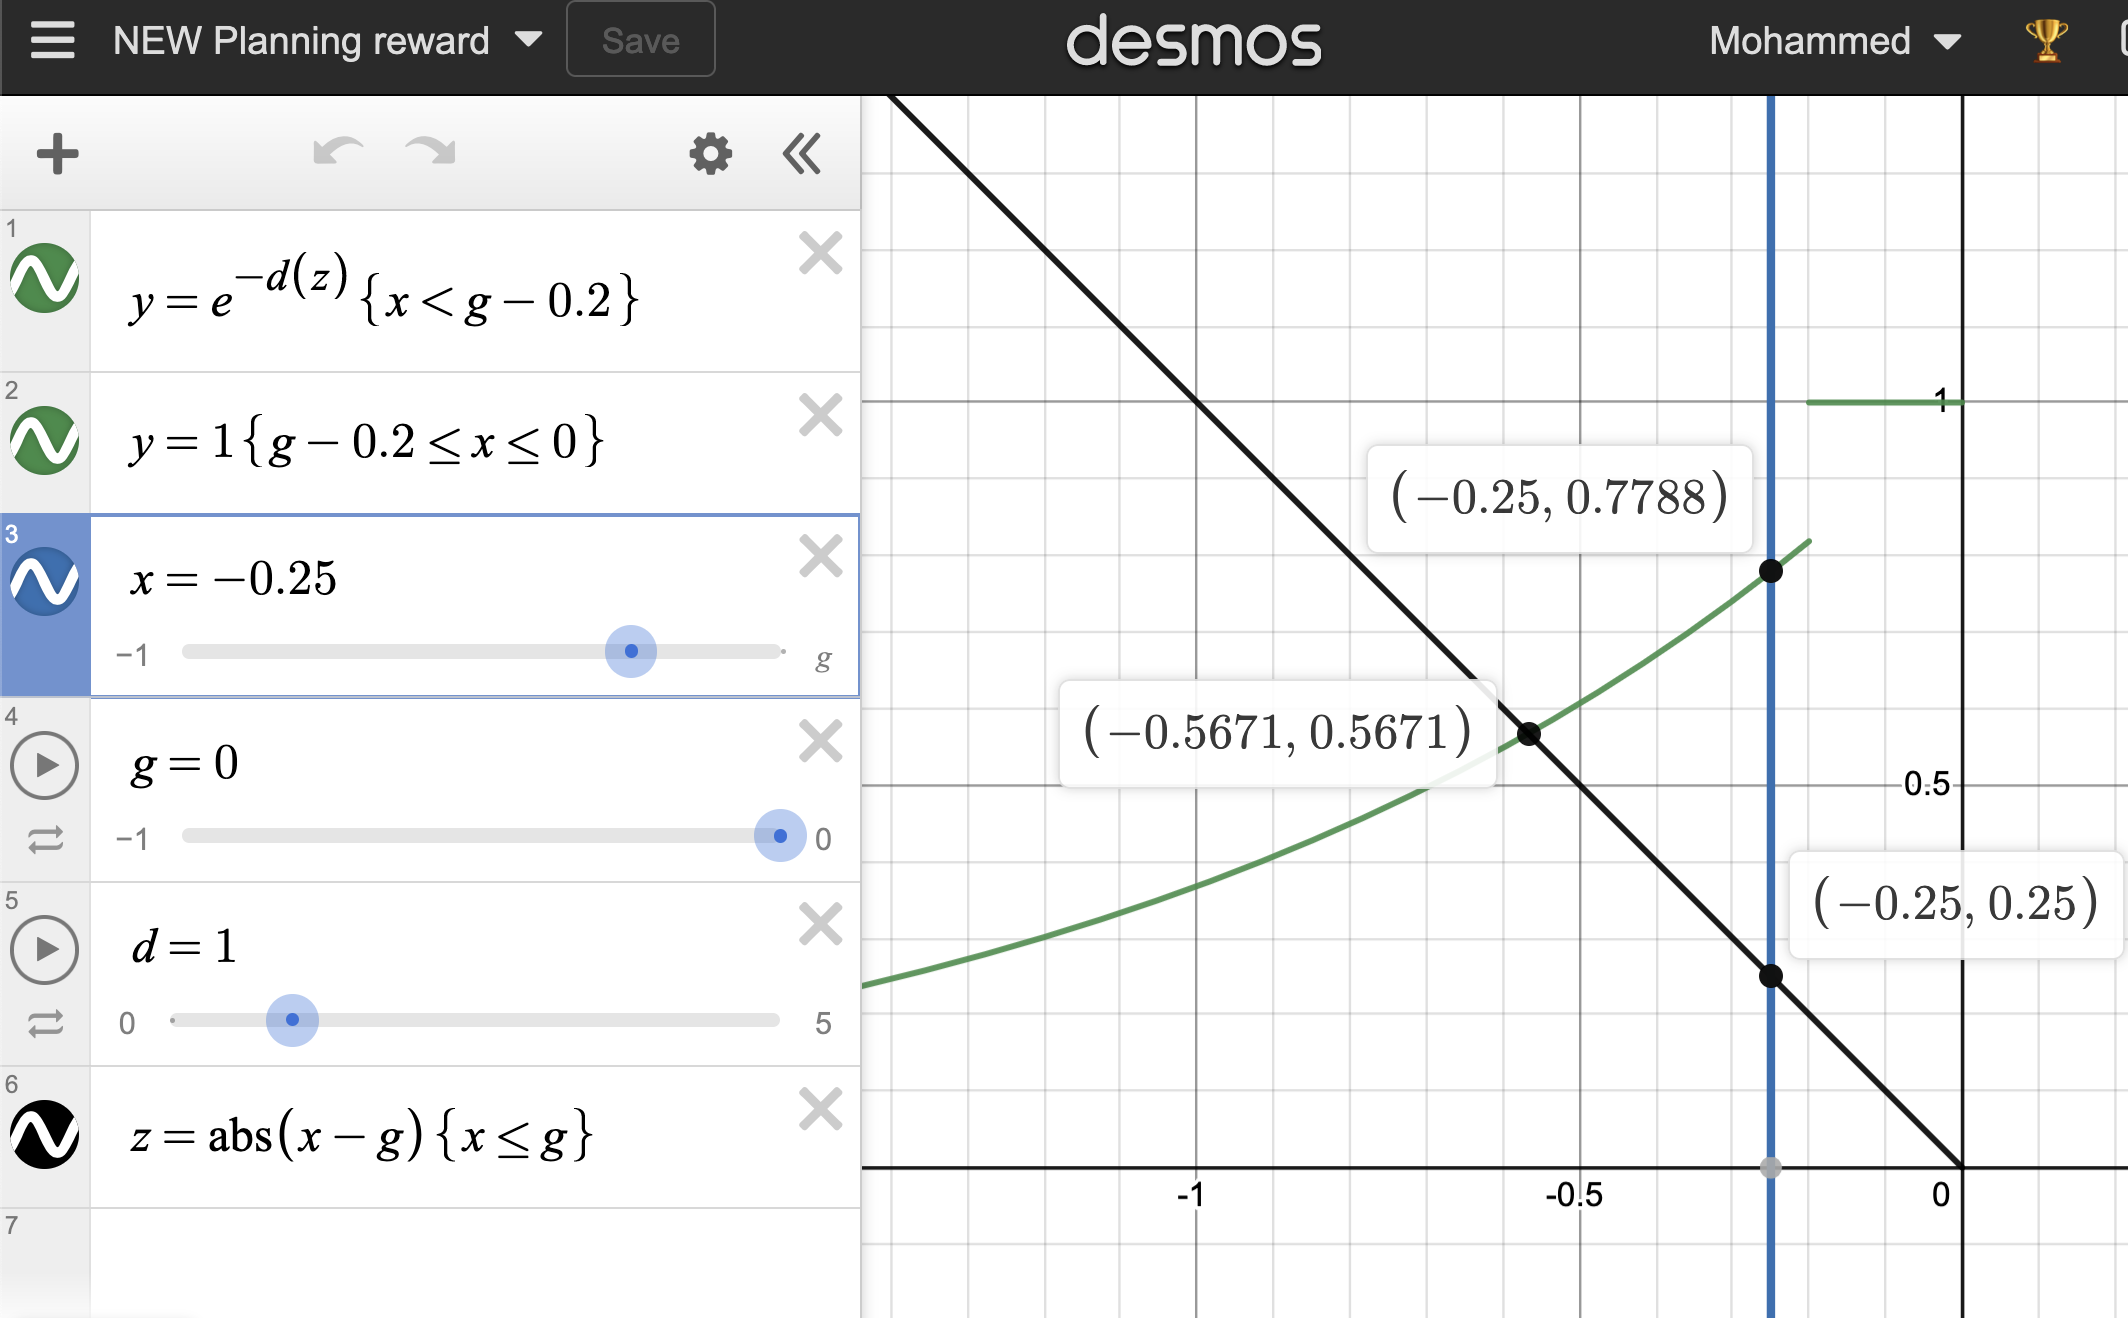

In [1]:
from IPython.display import Image

Image(filename='preward.png')

For the control policy reward, it depends on the distance between the robot's toe (x) and the determined bezier curve (b). We can see that the reward increases as the toe position gets closer to the bezier curve.

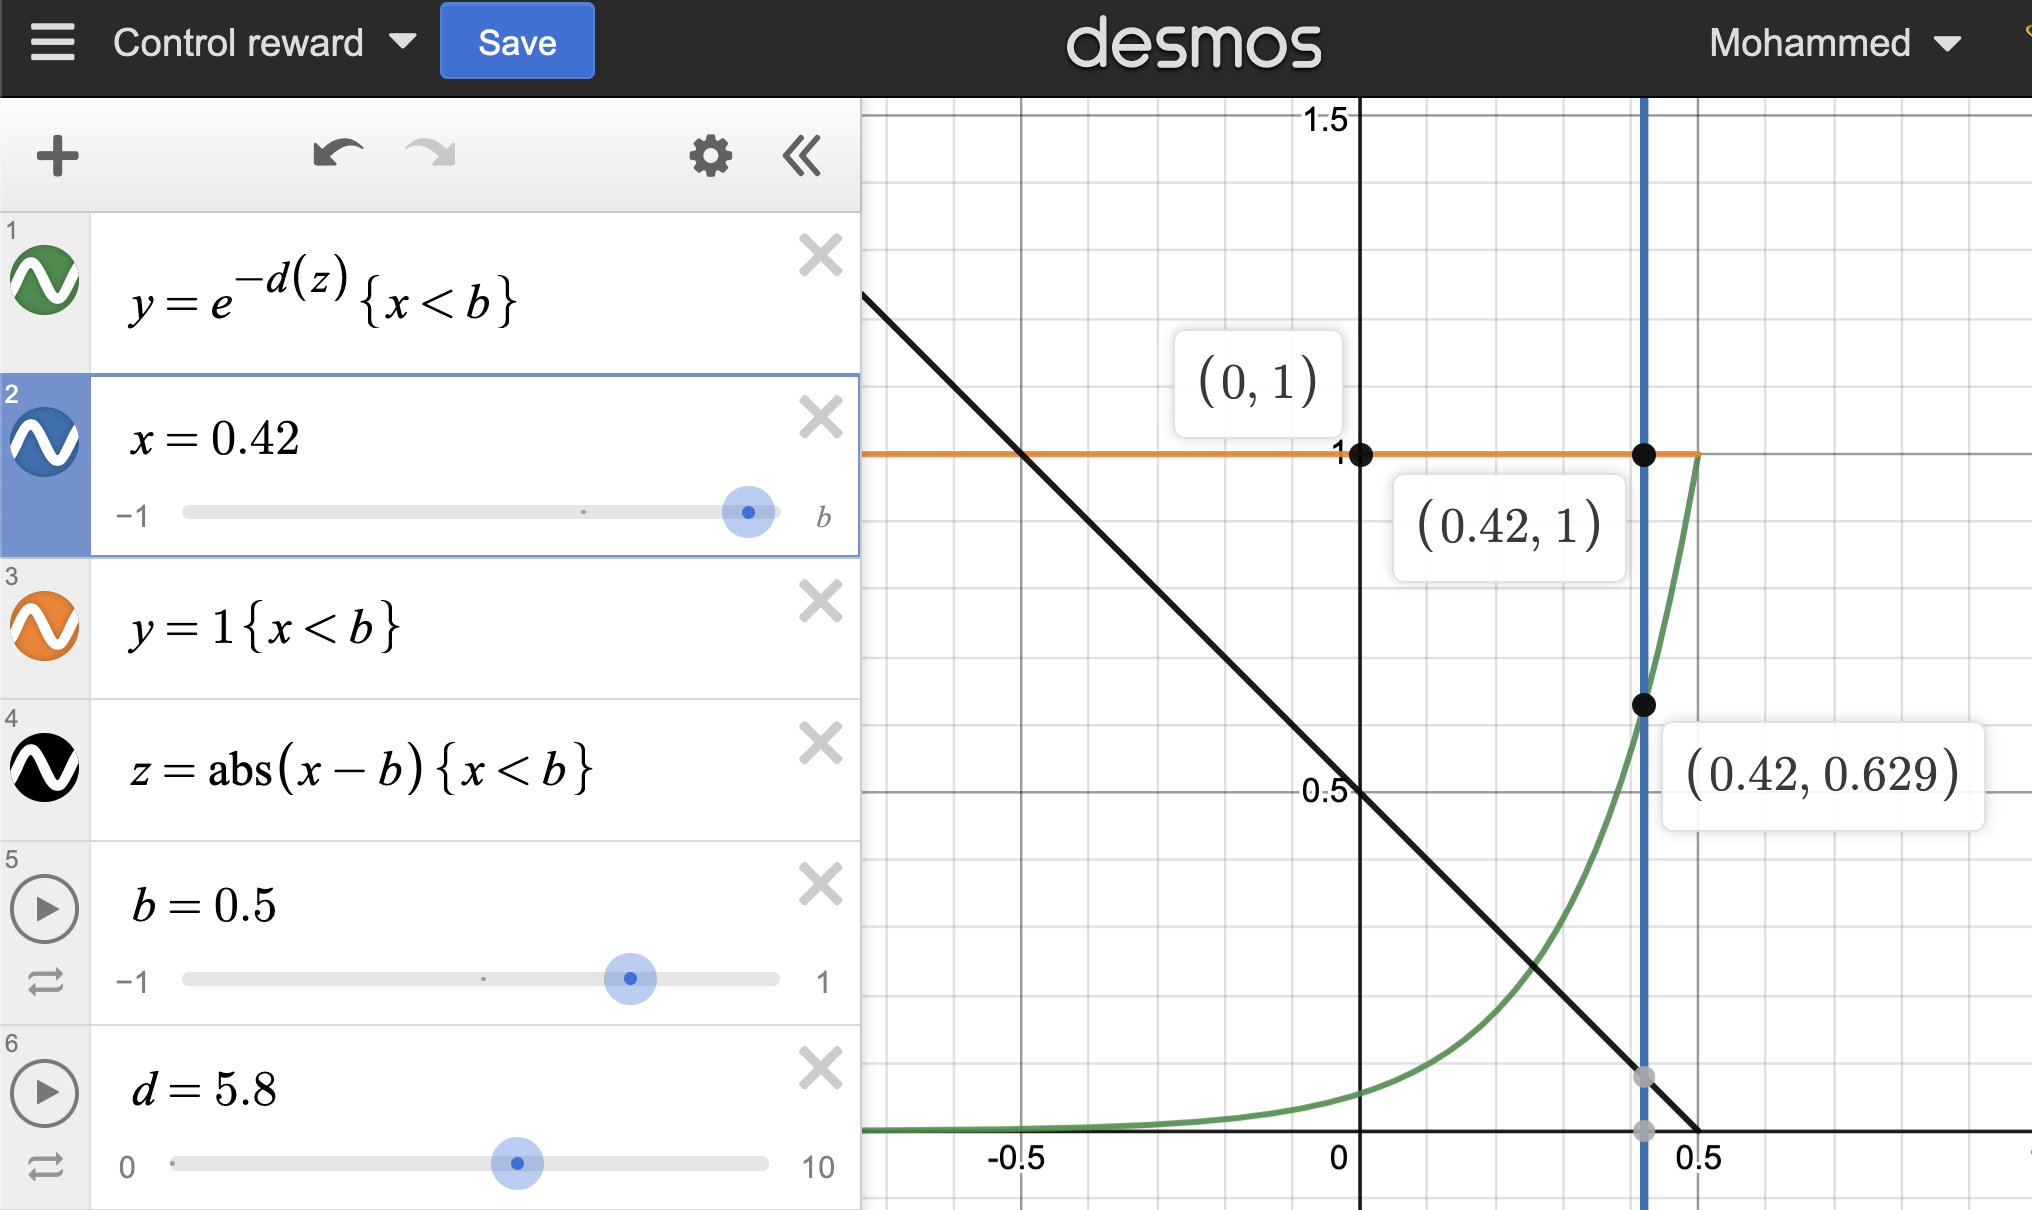

In [2]:
from IPython.display import Image

Image(filename='creward.png')

# Control Policy Problem Formulation
- **Action space**
    1. $a_{k}^{c} = q_{m}^{d} \in \R^{12}$ → LPF → PD → $\tau \in \R^{12}$
        - LPF: Low Pass Filter
        - PD: Joint-level PD controller
        - $\tau$: Torques

- **State space**
    1. $\delta \in \{0, 1, 2, 3\}$
        - Motion selector
    2. $\alpha \in \R^{3 \times 5}$
        - Desired Bezier parameters
        - Each column is an xyz point/parameter
    3. $T_{\delta}$
        - Trajectory time span
            - Motion segment time
    4. $t \in [0, 1]$
        - Current motion phase scaled by timespan $T_{\delta}$
            - Percentage of the motion segment done
    5. $q_{m} \in \R^{12}, q_{\psi, \theta, \phi} \in \R^{3}$ for each time step, $k$
        - Joint values and robot orientation
        - Robot’s current and past 6 states
    6. $a_{k-1:k-6}^{c}$
        - History of last 6 time steps of previous actions

- **Reward function**
    1. $r_{c, k} \in [0, 1]$
        - Where:
            - $r^{e}_{c, k} = \exp(-\delta^{e}||x_{e, k} - B_{\alpha}(t)||^{2}_{2})$
                - $B_{\alpha}(t)$: Reference toe position/Bezier curve
            - $\rho^{e}>0$: Scaling variable designed to encourage the toe to follow the reference curve obtained by Bezier parameters $\alpha$
            - $w_{c}^{T}$: Normalization weight vector with dominant weight on the toe, $r^{e}_{c, k}$

## Development of Control Policy

### Initial Environment Setup:
- Modified the existing `A1SoccerEnv` to suit the specific needs of the control policy training.
- Focused on the robot's internal state and actions, rather than external elements like the ball's position.

### Custom State Components:
- Added new state components relevant to the control policy, such as:
  - Motion phase selector (`self.motion_phase_selector`).
  - Bézier curve parameters (`self.bezier_parameters`) for desired end-effector trajectories.
  - Historical data of the robot's joint positions and orientations.

### Observation Space Refinement:
- Refined the observation space to include these new state components.
- Ensured that the observation space aligns with the control policy’s requirements, focusing on the robot's immediate state and action history.

### State Update Methods:
- Implemented methods to update the robot's state:
  - `update_robot_state`: Updates joint positions and orientations.
  - `update_action_history`: Maintains a history of recent actions.
- These methods are crucial for providing the control policy with accurate, real-time feedback on the robot's state and actions.

### Observation Construction:
- Developed a method (`_get_control_policy_obs`) to construct the observation array for the control policy.
- This method combines standard MuJoCo observations with the custom state components.

### Environment Interaction Methods:
- Refined the `step` and `reset` methods of the environment:
  - `reset_model`: Reinitializes the environment and the custom state components at the start of each episode.
  - `step`: Applies actions to the environment, updates the state, and returns the new observation and reward.

### Reward Function Design:
- Although the specific details of the reward function are not discussed here, it's an essential component of the control policy training, guiding the robot toward desired behaviors.

## Progress Summary

- By focusing on these aspects, I have laid the foundational work necessary for training an effective control policy for the A1 robot in a soccer environment.
- This work has been aligned with the principles and requirements outlined in the research paper, ensuring that the developed control policy is grounded in robust, research-backed methodologies.
- The next steps would involve training the control policy using reinforcement learning algorithms and then integrating it with the planning policy for higher-level decision-making.

This summary encapsulates the key progress and developments made in the `CustomA1SoccerEnv` environment, emphasizing the steps taken to prepare for the training of a control policy.

# Updated pipeline and environment setup: A1SoccerEnv_v2

Currently, this environment adheres to the observation spaces definition defined above. The only two components missing to enable the new training pipeline is defining the step() and reward() methods. However, as all the helper observation methods are already tested and defined, that should be relatively straightforward. 

In [ ]:
__credits__ = ["MohammedBadra"]

from typing import Dict
import numpy as np
import math
import time
import random

from gymnasium import utils
from gymnasium.envs.mujoco import MujocoEnv
# from gymnasium.spaces import Box
from gymnasium import spaces

from scipy.spatial.transform import Rotation as R

DEFAULT_CAMERA_CONFIG = {"distance": 4.0,}

################################################################################################################################
class A1SoccerEnv_v2(MujocoEnv, utils.EzPickle):
    ############################################################################################################################
    #Old method
    metadata = {
        "render_modes": [
            "human",
            "rgb_array",
            "depth_array",],}

    def __init__(
        self,
        xml_file: str = "a1_soccer_v1.xml",
        frame_skip: int = 5,
        default_camera_config: Dict[str, float] = DEFAULT_CAMERA_CONFIG,
        forward_reward_weight: float = 1.0,
        ctrl_cost_weight: float = 0.1,
        reset_noise_scale: float = 0.1,
        exclude_current_positions_from_observation: bool = True,
        **kwargs,
    ):
        utils.EzPickle.__init__(
            self,
            xml_file,
            frame_skip,
            default_camera_config,
            forward_reward_weight,
            ctrl_cost_weight,
            reset_noise_scale,
            exclude_current_positions_from_observation,
            **kwargs)

        self._forward_reward_weight = forward_reward_weight
        self._ctrl_cost_weight = ctrl_cost_weight
        self._reset_noise_scale = reset_noise_scale
        self._exclude_current_positions_from_observation = (
            exclude_current_positions_from_observation)

        MujocoEnv.__init__(
            self,
            xml_file,
            frame_skip,
            observation_space=None,
            default_camera_config=default_camera_config,
            **kwargs,
        )

        self.metadata = {
            "render_modes": [
                "human",
                "rgb_array",
                "depth_array",
            ],
            "render_fps": int(np.round(1.0 / self.dt)),
        }
        
        self.robot_joint_count = 12  # This is based on your previous information
        
    
    ################################################################################################################################
    #New init method content

        #1. motion selector, delta
        self.motion_phase_selector = 0
        #2. bezier parameters, alpha
        self.bezier_parameters = np.zeros((3, 5))

        #3. duration of current motion phase, T_d
        self.motion_phase_time_span = 0
        #4. current motion phase progress, t
        self.motion_phase_progress = 0

        #5.
        #robot current state
        self.robot_joint_positions_current = np.zeros((1, 12))
        self.robot_orientation_current = np.zeros((1, 3))

        #robot current and last 6 states
        self.robot_joint_positions_history = np.zeros((7, 12))
        self.robot_orientation_history = np.zeros((7, 3))

        #6. last 6 actions history
        self.action_current = np.zeros((1, 12))        
        self.action_history = np.zeros((6, 12))

        ###################################################################################################
        #time parameters
        #running the step at 30Hz
        #0.002 is the time step of the mujoco simulation
        self.step_dt = 30
        self.frame_skip = int(((1 / self.step_dt) / 0.002))

        ###################################################################################################
        #observation size and structure for the control policy
        # Dimensions of the new state components
        motion_phase_selector_dim = 1
        bezier_parameters_dim = 3 * 5  # 3 coordinates for each of the 5 Bézier points
        motion_phase_time_span_dim = 1
        motion_phase_progress_dim = 1
        combined_history_dim = 7 * (self.robot_joint_count + 3)  # 7 timesteps, joint positions + orientation for each
        action_history_dim = 6 * self.robot_joint_count  # 6 timesteps, self.robot_joint_count action values each

        # Calculate the total size of the observation
        obs_size = (
            motion_phase_selector_dim
            + bezier_parameters_dim
            + motion_phase_time_span_dim
            + motion_phase_progress_dim
            + combined_history_dim  # Joint positions and orientation combined
            + action_history_dim
        )

        # Redefine the observation structure for the control policy
        self.observation_structure = {
            "motion_phase_selector": motion_phase_selector_dim,
            "bezier_parameters": bezier_parameters_dim,
            "motion_phase_time_span": motion_phase_time_span_dim,
            "motion_phase_progress": motion_phase_progress_dim,
            "combined_robot_state_history": combined_history_dim,  # Joint positions and orientation history combined
            "action_history": action_history_dim}
        
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(obs_size,), dtype=np.float64)

    ###################################################################################################
    #Old environment methods

    def calculate_reward(self, ball_position_before, ball_position_after, ctrl_cost):
        # Upright reward
        upright_vector = np.array([0, 0, 1])  # Assuming z-axis is up
        robot_up_vector = self.data.body_xpos[self.robot_body_index][2]  # Adjust this as needed
        upright_reward = np.dot(upright_vector, robot_up_vector)

        # Shooting towards goal reward
        goal_center = np.array([self.goal_position_x, self.goal_position_y, 0])  # Adjust as needed
        ball_movement_direction = ball_position_after - ball_position_before
        distance_to_goal_after_action = np.linalg.norm(goal_center - ball_position_after)
        distance_to_goal_before_action = np.linalg.norm(goal_center - ball_position_before)
        goal_reward = distance_to_goal_before_action - distance_to_goal_after_action  # Positive if ball moved closer to the goal

        # Combine rewards
        # self._upright_weight = 10000
        reward = self._upright_weight * upright_reward + self._goal_weight * goal_reward - ctrl_cost

        return reward
    
    def control_cost(self, action):
        control_cost = self._ctrl_cost_weight * np.sum(np.square(action))
        return control_cost

    def step(self, action):
        # current_timestamp = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        # print(f"Hi from step! timestamp is {current_timestamp}")

        x_position_before = self.data.qpos[0]
        self.do_simulation(action, self.frame_skip)
        x_position_after = self.data.qpos[0]
        x_velocity = (x_position_after - x_position_before) / self.dt

        ctrl_cost = self.control_cost(action)

        forward_reward = self._forward_reward_weight * x_velocity

        observation = self._get_obs()
        reward = forward_reward - ctrl_cost
        info = {
            "x_position": x_position_after,
            "x_velocity": x_velocity,
            "reward_forward": forward_reward,
            "reward_ctrl": -ctrl_cost,
        }

        if self.render_mode == "human":
            self.render()
        return observation, reward, False, False, info

    ###################################################################################################
    #New environment methods
    def get_robot_joint_positions(self):
        qpos = self.data.qpos
        joint_positions = qpos[14:26]

        return joint_positions

    def get_robot_orientation(self):
        qpos = self.data.qpos
        # Extract the robot's root orientation quaternion
        robot_orientation_quat = qpos[10:14]

        # Convert quaternion to Euler angles
        # The 'xyz' sequence implies intrinsic rotations around X, Y, Z axes respectively
        robot_orientation_euler = R.from_quat(robot_orientation_quat).as_euler('xyz', degrees=False)

        # robot_orientation_euler is an array [roll, pitch, yaw]
        roll_angle = robot_orientation_euler[0]  # Roll angle about X axis (qψ)
        pitch_angle = robot_orientation_euler[1] # Pitch angle about Y axis (qθ)
        yaw_angle = robot_orientation_euler[2]   # Yaw angle about Z axis (qφ)

        return robot_orientation_euler

    def update_robot_state(self):
        #joints state update
        self.robot_joint_positions_current = self.get_robot_joint_positions()
        #moving the old current to the back
        self.robot_joint_positions_history = np.roll(self.robot_joint_positions_history, -1, axis = 0)
        #replacing the old current with the new current
        self.robot_joint_positions_history[-1] = self.robot_joint_positions_current

        #orientation state update
        self.robot_orientation_current = self.get_robot_orientation()
        self.robot_orientation_history = np.roll(self.robot_orientation_history, -1, axis = 0)
        self.robot_orientation_history[-1] = self.robot_orientation_current

        return self.robot_joint_positions_history, self.robot_orientation_history
    
    def update_action_history(self):
        #this method should be called after the action is taken and before a new action is generated
        self.action_history = np.roll(self.action_history, -1, axis = 0)
        self.action_history[-1] = self.action_current

        return self.action_history

    def update_motion_phase_selector(self):
        if self.motion_phase_progress == 1:
            if self.motion_phase_selector == 3:
                self.motion_phase_selector = 0
            else:
                self.motion_phase_selector += 1
    
    def update_motion_phase_progress(self):
        self.motion_phase_progress += self.step_dt / self.motion_phase_time_span

        if self.motion_phase_progress > 1:
            print("Motion phase progress overflow")

    def initialize_random_bezier(self):
        #size of each bezier parameter vector
        size = (3, 1)

        #an educated guess of bezier parameters range between -0.5m and 0.5m
        lower_bound = -0.5
        upper_bound = 0.5

        #the first random value is for variation, the second is for the initial value
        #the second value will be substituted by the input from the planning policy once ready
        alpha_0 = np.random.uniform(-0.1, 0.1, size) + np.random.uniform(lower_bound, upper_bound, size)
        alpha_1 = np.random.uniform(-0.1, 0.1, size) + np.random.uniform(lower_bound, upper_bound, size)
        alpha_4 = np.random.uniform(-0.1, 0.1, size) + np.random.uniform(lower_bound, upper_bound, size)

        alpha_2 = np.random.uniform(-0.1, 0.3, size) + np.random.uniform(lower_bound, upper_bound, size)
        alpha_3 = np.random.uniform(-0.1, 0.3, size) + np.random.uniform(lower_bound, upper_bound, size)

        return np.array([alpha_0, alpha_1, alpha_2, alpha_3, alpha_4])

    def initialize_random_time_span(self):
        #deciding the motion phase time span depending on the kind of motion performed
        if self.motion_phase_selector == 0:
            self.motion_phase_time_span = random.uniform(1.0, 4.0)
        elif self.motion_phase_selector == 1:
            self.motion_phase_time_span = random.uniform(3.0, 4.0)
        elif self.motion_phase_time_span == 2:
            self.motion_phase_time_span = random.uniform(0.2, 0.4)
        elif self.motion_phase_time_span == 3:
            self.motion_phase_time_span = random.uniform(1.0, 3.0)

        return self.motion_phase_time_span   

    def _get_obs(self):
        qpos = self.data.qpos
        qvel = self.data.qvel

        # Standard observations from MuJoCo
        # saved for later for planning policy
        standard_obs = np.concatenate([
            qpos[:7],      # ball qpos
            qvel[:6],      # ball qvel
            qpos[7:14],    # robot root qpos
            qvel[6:12],    # robot root qvel
            qpos[14:26],   # robot joints qpos
            qvel[12:24]    # robot joints qvel
        ])

        # Combine joint positions and orientations history into one variable
        combined_robot_state_history = np.concatenate([self.robot_joint_positions_history,
                                                        self.robot_orientation_history], axis=1).flatten()

        #Control policy state/observation space
        control_policy_observation = np.concatenate([
            np.array([self.motion_phase_selector]),                # motion selector
                        self.bezier_parameters.flatten(),          # Bézier parameters
                        np.array([self.motion_phase_time_span,     # duration of current motion phase
                        self.motion_phase_progress]),              # current motion phase progress
                        combined_robot_state_history,              # combined history of joint positions and orientations
                        self.action_history.flatten()])            # last 6 actions history

        return control_policy_observation

    def print_obs(self):
        obs_array = self._get_obs()
        obs_index = 0

        for key, size in self.observation_structure.items():
            # Extract the segment of the observation array corresponding to the current key
            value = obs_array[obs_index:obs_index + size]
            print(f"{key}:\n{value}\n")
            
            # Update the index to the start of the next segment
            obs_index += size

        # Check if the entire observation array has been covered
        if obs_index != len(obs_array):
            print("Warning: Observation array size does not match the total size defined in observation_structure.")

    def place_components(self):
        #places the robot and ball in random positions, while making sure the robot is facing forward
        noise_low = -self._reset_noise_scale
        noise_high = self._reset_noise_scale

        # Initial positions and velocities
        qpos = np.array(self.init_qpos)
        qvel = np.array(self.init_qvel)

        # Modify robot's orientation to face the goal
        robot_root_orientation_indices = slice(10, 14)

        theta = math.radians(90)
        qw = math.cos(theta / 2)
        qx = 0
        qy = 0
        qz = math.sin(theta / 2)

        robot_orientation = [qw, qx, qy, qz]
        qpos[robot_root_orientation_indices] = robot_orientation

        # Introduce randomness to the ball's initial position
        ball_offset = np.random.uniform(-0.05, 0.05, size=(3,))
        qpos[:3] += ball_offset  # Assuming ball's qpos is first

        # Optional: Introduce some randomness to the robot's root position and orientation for more variability
        qpos[7:10] += self.np_random.uniform(low=noise_low, high=noise_high, size=3)  # Robot root position
        qpos[robot_root_orientation_indices] += self.np_random.uniform(low=-0.05, high=0.05, size=4)  # Robot root orientation

        # Optional: Introduce randomness to the robot's joint positions and velocities
        joint_noise = self.np_random.uniform(low=noise_low, high=noise_high, size=12)  # Assuming 12 joints
        qpos[14:26] += joint_noise

        # Adjusting this line to target the correct slice for robot's joint velocities:
        qvel[12:24] += joint_noise * 0.1  # Smaller noise for velocities


        # Set the state
        self.set_state(qpos, qvel)

    def reset_model(self):
        #places the robot and on the field and initializes its effective joint and orientation values
        self.place_components()

        # Reinitialize custom state components
        self.motion_phase_selector = 0
        self.bezier_parameters = self.initialize_random_bezier()
        self.motion_phase_time_span = self.initialize_random_time_span()
        self.motion_phase_progress = 0

        self.robot_joint_positions_current = np.zeros((1, 12))
        self.robot_joint_positions_history = np.zeros((7, 12))
        self.robot_orientation_current = np.zeros((1, 3))
        self.robot_orientation_history = np.zeros((7, 3))

        self.action_current = np.zeros((1, 12))
        self.action_history = np.zeros((6, 12))

        # Return the observation
        return self._get_obs()

# References

- Ji, Y., Li, Z., Sun, Y., Peng, X. B., Levine, S., Berseth, G., & Sreenath, K. (2022, October). Hierarchical reinforcement learning for precise soccer shooting skills using a quadrupedal robot. In 2022 IEEE/RSJ International Conference on Intelligent Robots and Systems (IROS) (pp. 1479-1486). IEEE.
    * This paper solved the same problem I am solving, thus I am using their approach as a reference. However, I don't have any of their code so I am rebuilding everything from scratch. Currently, I am working on replicating their results. Next, I am to extend it to more complex soccer ball manipulation skills